## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
import requests
import pandas as pd

# disable SSL warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = 'https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet'
response = requests.get(url, verify=False)

with open('Phishing_Email.parquet', 'wb') as f:
    f.write(response.content)

df = pd.read_parquet('Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

To clean the tokens and use them for predicting phishing emails, I would start by converting all text to lowercase for consistency. Next, I'd remove punctuation, special characters, and numbers that aren't relevant to phishing detection. Eliminating common stop words would help focus on more meaningful content. 

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

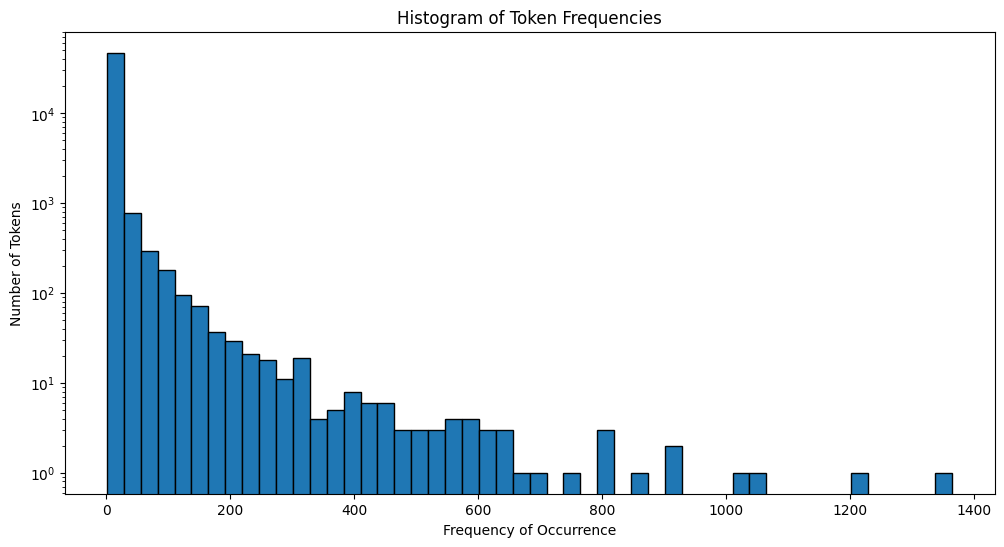

Total unique tokens: 48691
Maximum frequency: 1365
Minimum frequency: 1


In [6]:
import matplotlib.pyplot as plt

frequencies = [count for word, count in token_freq]

plt.figure(figsize=(12, 6))
plt.hist(frequencies, bins=50, edgecolor='black')
plt.title('Histogram of Token Frequencies')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Number of Tokens')
plt.yscale('log')  
plt.show()

print(f"Total unique tokens: {len(frequencies)}")
print(f"Maximum frequency: {max(frequencies)}")
print(f"Minimum frequency: {min(frequencies)}")

The histogram shows a long-tailed distribution. There will be a large number of tokens that appear only a few times (visible as tall bars on the left side of the histogram), and a small number of tokens that appear very frequently (visible as short bars on the right side, extending far along the x-axis).

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

lm_0 = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)

print('train R^2: ', r2_score(y_train, y_hat_train_0))
print('test R^2: ', r2_score(y_test, y_hat_test_0))

rdf = pd.DataFrame({'variable': lm_0.feature_names_in_, 'value': lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
top_words = rdf.sort_values('abs', ascending=False).head(10)

print("\nTop 10 words with largest absolute coefficients:")
print(top_words[['variable', 'value']])

train R^2:  0.6946773880978026
test R^2:  -9.048782659210088e+21

Top 10 words with largest absolute coefficients:
                                               variable         value
74                                                2002,  8.593033e+12
1798  url(http://images.lockergnome.com/images/issue... -8.290013e+12
1034                                         underline;  8.290013e+12
1672                                               cbs,  7.799277e+12
33                                                 2001 -7.075050e+12
40                                                 2000 -6.391990e+12
1574                                                13, -6.127388e+12
72                                                 1998  5.868858e+12
668                                                 500  5.561088e+12
1674                                             oprah! -5.458943e+12


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

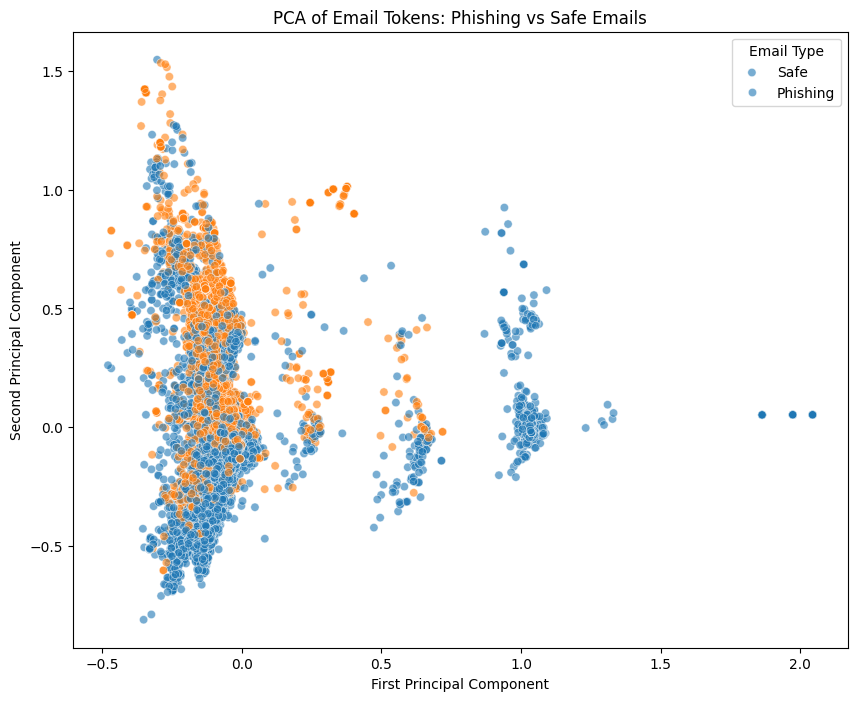

Explained variance ratio: [0.0111309  0.00861056]


In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('Phishing_clean.parquet')

X = df.drop('Email Type', axis=1)
y = df['Email Type']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', alpha=0.6)
plt.title('PCA of Email Tokens: Phishing vs Safe Emails')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title='Email Type', labels=['Safe', 'Phishing'])
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

The scatter plot of the first two principal components shows significant overlap between the orange (phishing emails) and blue (safe emails) dots.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [13]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pca = PCA(n_components=2610)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=125)

lm_pca = LinearRegression().fit(X_train_pca, y_train)

train_r2_pca = r2_score(y_train, lm_pca.predict(X_train_pca))
test_r2_pca = r2_score(y_test, lm_pca.predict(X_test_pca))

print(f"PCA Regression - Train R^2: {train_r2_pca:.4f}")
print(f"PCA Regression - Test R^2: {test_r2_pca:.4f}")

PCA Regression - Train R^2: 0.7651
PCA Regression - Test R^2: 0.6707


The PCA-based regression model significantly outperforms the original linear regression model, achieving a training R² of 0.7651 and a test R² of 0.6707, compared to the original model's training R² of 0.6215 and a negative test R² of -0.0003. This indicates that the PCA model not only fits the training data better but also generalizes well to unseen data, making it more effective for predicting phishing emails.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components for high-dimensional regression has several advantages. Firstly, it reduces dimensionality by transforming the original features into a smaller set of uncorrelated components that capture the most significant variance in the data. This helps to mitigate issues like multicollinearity and noise, leading to improved model performance and generalization on unseen data. Secondly, it can simplify the model, making it easier to interpret and less prone to overfitting.
However, there are also drawbacks to this approach. One major limitation is that principal components can be difficult to interpret, as they are linear combinations of the original features and may not correspond to meaningful variables in the context of the problem.